# TODOs:
- [ ]  Make sure eyes are croped without the haarcascades eye detector
- [ ]  Make haarcascades square bigger for more orbit of the eye?
- [ ]  Distinguish between affected and not affected eyes?
- [ ]  Size of images to be 224x224, 150x150, smaller?

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    skin_files = np.array(data['filenames'])
    skin_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return skin_files, skin_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/train')
valid_files, valid_targets = load_dataset('data/validation')
test_files, test_targets = load_dataset('data/test')

# load list of skin names
skin_names = [item[20:-1] for item in sorted(glob("data/train/*/"))]

# print statistics about the dataset
print('There are %d total skin categories.' % len(skin_names))
print('There are %s total skin images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training skin images.' % len(train_files))
print('There are %d validation skin images.' % len(valid_files))
print('There are %d test skin images.'% len(test_files))

Using TensorFlow backend.


There are 2 total skin categories.
There are 36 total skin images.

There are 12 training skin images.
There are 12 validation skin images.
There are 12 test skin images.



## Step 1: Detect Human Eyes

We use OpenCV's implementation of Haar feature-based cascade classifiers to detect human faces in images. OpenCV provides many pre-trained face detectors, stored as XML files on github. We have downloaded one of these detectors and stored it in the haarcascades directory.
In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of eyes detected: 2


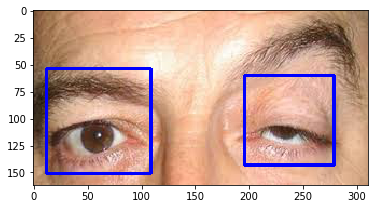

In [14]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# load filenames in human dataset
# full_eyes_db containd the db with all of our images
human_files = np.array(glob("data/full_eyes_db/*"))

# extract pre-trained eye detector
eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_lefteye_2splits.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])

# it is standard procedure to convert the images to grayscale
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find eyes in image
eyes = eye_cascade.detectMultiScale(gray)

# print number of eyes detected in the image
print('Number of eyes detected:', len(eyes))

# get bounding box for each detected eye
for (x,y,w,h) in eyes:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

## Crop Eyes
We use this cell to crop eyes from our data set and have them ready to separate between eyes with the disease and eyes without it.

In [5]:
# import os
# import sys

# num = 0

# for (x,y,w,h) in eyes:
#     crop_img = img[y:y+h, x:x+w]
#     # Store detected eyes in the following folder, does not distinguish between affected and not affected.
#     path = 'data/train'
#     cv2.imwrite(os.path.join(path , 'image{}.jpg'.format(num)), crop_img)
#     num += 1


We can use this procedure to write a function that returns True if a human face is detected in an image and False otherwise. This function, aptly named face_detector, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray)
    return len(eyes) > 0

## Pre-process the Data

```path_to_tensor``` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN. The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels. Next, the image is converted to an array, which is then resized to a 4D tensor. In this case, since we are working with color images, each image has three channels. Likewise, since we are processing a single image (or sample), the returned tensor will always have shape
$$
(1, 224, 224, 3).
$$

In [4]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [21]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [22]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

We generate some pictures using ImageDataGenerator from Keras and save them to a temporary directory called preview, so we can get a feel for what our augmentation strategy is doing --we disable rescaling in this case to keep the images displayable.

In [24]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# Use the following code to have an idea of how this technique will look like

img = load_img('data/crop_eyes/IMAGE_TO_LOAD.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 224, 224)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 224, 224)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='melanoba', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

### Training the model with no transfer learning

In [30]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255




  0%|          | 0/7 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:00<00:00, 128.65it/s]


  0%|          | 0/7 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:00<00:00, 115.30it/s]


  0%|          | 0/9 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 107.79it/s]

In [31]:
print(train_tensors.shape)
print(valid_tensors.shape)
print(test_tensors.shape)

(7, 150, 150, 3)
(7, 150, 150, 3)
(9, 150, 150, 3)


In [32]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Exception ignored in: <bound method tqdm.__del__ of   0%|          | 0/11 [01:51<?, ?it/s]>
Traceback (most recent call last):
  File "/anaconda3/envs/quadcop/lib/python3.6/site-packages/tqdm/_tqdm.py", line 879, in __del__
    self.close()
  File "/anaconda3/envs/quadcop/lib/python3.6/site-packages/tqdm/_tqdm.py", line 1098, in close
    self._decr_instances(self)
  File "/anaconda3/envs/quadcop/lib/python3.6/site-packages/tqdm/_tqdm.py", line 438, in _decr_instances
    cls._instances.remove(instance)
  File "/anaconda3/envs/quadcop/lib/python3.6/_weakrefset.py", line 109, in remove
    self.data.remove(ref(item))
KeyError: <weakref at 0x1a24aa5b88; to 'tqdm' at 0xb229852e8>


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 110, 110, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 53, 64)        18496     
__________

In [6]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 224x224
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

NameError: name 'ImageDataGenerator' is not defined

In [34]:
model.fit_generator(
        train_generator,
        steps_per_epoch=200 // batch_size,
        epochs=1,
        validation_data=validation_generator,
        validation_steps=400 // batch_size)
model.save('first_try.h5')  # we always save our weights after training or during training

Epoch 1/1
12/12 [==============================] - 55s 5s/step - loss: 2.5211 - acc: 0.6190 - val_loss: 0.5642 - val_acc: 1.0000


In [41]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# dimensions of our images
img_width, img_height = 224, 224

# load the model we saved
model = load_model('first_try.h5')
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# predicting images
img = image.load_img('data/test/normal/1.jpeg', target_size=(img_width, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10, verbose=1)
print(classes)


# print the classes, the images belong to
print(classes)
print(classes[0])
print(classes[0][0])

1/1 [==============================] - 1s 1s/step
[[1.4010159e-35]]
[[1.4010159e-35]]
[1.4010159e-35]
1.4010159e-35
